In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import warnings
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")

Two auction lists of car for sales were uploaded in this project which were acceessable from IAAI.com,the digits in the file name
show the date of auction
reading the auction list file which is avaialble for public and dealer for a week before auction in  different barnches on https://www.iaai.com/LiveAuctions
My target branch is in Detroit    

In [3]:

first_automobile_auctionlist = pd.read_csv(r'Documents/BranchSalesListItems_07082019.csv')
second_automobile_auctionlist = pd.read_csv(r'Documents/BranchSalesListItems_07252019.csv')

Concatenate two files into a new file  and show list of all cars in auction avaliable for sales

In [4]:
automobile=pd.concat([first_automobile_auctionlist ,second_automobile_auctionlist], ignore_index=True)
automobile.head()


,Stock#,Lane,Item#,Year,Make,Model,Odometer,VIN,Sale Document,Loss Type,...,Primary Damage,Secondary Damage,Run & Drive,Starts,Odometer Status,Fuel Type,Cylinders,Transmission,Provider,Buy Now Price
0,25239190,NaN,#TBD,2005,ACURA,MDX,"142,876",2HNYD18945H533515,SALVAGE CERTIFICATE-CA,COLLISION,...,FRONT END,LEFT & RIGHT,NO,NO,ACTUAL,Gasoline,6 Cyl,Automatic,Mercury Insurance,$675.00
1,25162867,NaN,#TBD,2011,AUDI,Q5,"79,500",WA1WKAFP4BA058134,PREVIOUS SALVAGE-MI,WATER,...,FLOOD,FRONT & REAR,NO,NO,ACTUAL,Gasoline,6 Cyl,Automatic,Progressive Casualty Insurance,"$5,700.00"
2,25397273,NaN,#TBD,2005,BENTLEY,CONTINENTAL,"71,045",SCBCR63W25C028848,CLEAR-FL,OTHER,...,NONE,UNKNOWN,YES,YES,ACTUAL,Gasoline,12 Cyl,Automatic,NaN,"$26,000.00"
3,25112456,NaN,#TBD,2013,BMW,328,"111,025",WBA3B3C58DF536341,CLEAR-MI,COLLISION,...,RIGHT SIDE,FRONT & REAR,YES,YES,ACTUAL,Gasoline,4 Cyl,Automatic,Progressive Casualty Insurance,NaN
4,25102838,NaN,#TBD,2004,BMW,330,"151,574",WBAEW53444PN35780,CLEAR-MI,COLLISION,...,FRONT & REAR,LEFT SIDE,NO,NO,ACTUAL,Gasoline,6 Cyl,Automatic,Hanover Insurance,NaN


Replacing odemeters of autos  which has a nan value with zero


In [5]:

automobile.Odometer=automobile.Odometer.fillna(0)

Classified cars in 4 segments , we are looking to analyze the price of cars in Economy segment and adding this segment to 
pur data frame

In [6]:
automobile.insert(4, "segment",  True)
def Classifysegment(make):
 
    Midlevel = ['Alfa Romeo', 'RAM','Chrysler', 'Infiniti', 'MINI', 'Volkswagen' , 'JEEP','CADILLAC','LINCOLN']
    Economy = ['TOYOTA' , 'HONDA','MAZDA' , 'CHEVROLET' , 'MERCURY','BUICK','SUBARU','VOLVO' ,'GMC','DODGE','KIA',
               'Saab', 'PONTIAC' , 'NISSAN' ,'JEEP']
    Luxury=['BMW','LEXSUS', 'MERCEDES-BENZ','PORSCHE','JAGUAR']
    SuperLuxury=['BENTLEY' , 'MASARATI']
   
    if make in Midlevel:
        return 'Midlevel'
    if make in Economy:
        return 'Economy'
    if make in Luxury:
        return 'Luxury'
    elif make in SuperLuxury:
        return 'SuperLuxury'
    
automobile['segment'] = [Classifysegment(make) for make in automobile.Make ]


 


This bar char below shows destribution of car by make in the IAA auto auction from those lists

Text(0.5, 1.0, 'Number of vehicles by make')

Text(0, 0.5, 'Number of vehicles')

Text(0.5, 1.0, 'Disdtribution of car for sales in auction by brand')

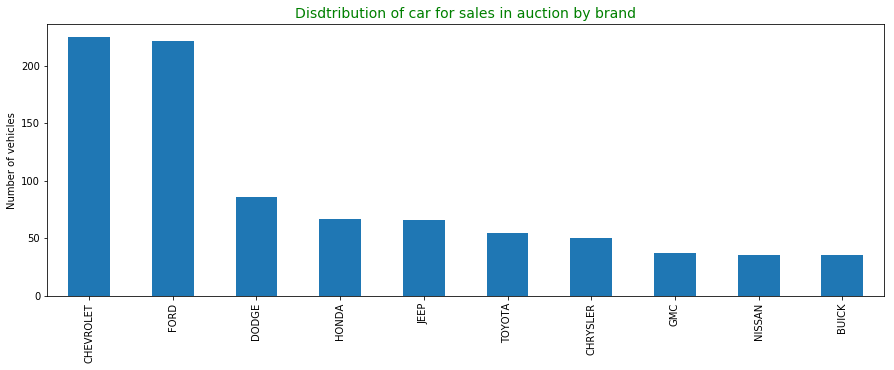

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
automobile.Make.value_counts().nlargest(10).plot(kind='bar', figsize=(15,5))
plt.title("Number of vehicles by make")
plt.ylabel('Number of vehicles')
plt.title('Disdtribution of car for sales in auction by brand', color='green', fontsize=14)
plt.show()

conver Milage DataType from string to Intiger. Then rename some columns and then regarding my 2 years experince in busyning and selling cars
filtering cars for sales in the auction to desirable list by some condition. This list  filter auction list to the most infuence for buyer targeting tax season cash 
no financing car with seler can sell them less than $5,000 with at least 25% profit 

In [8]:

automobile.Odometer=automobile.Odometer.astype(str).str.replace(",", "").astype(int)

automobile=automobile.rename(columns = {'Run & Drive':'Run','Sale Document':'SaleDoc','Primary Damage':'PrimaryDamage'
                                        ,'Run & Drive':'Run','Secondary Damage':'SecondaryDamage'})

df_filtered =automobile[(automobile.Odometer<= 160000 )&( automobile.Odometer > 80000 ) & (automobile.Starts == "YES")
                        & (automobile.Run == "YES") & (automobile.segment == "Economy") & (automobile.Year<= 2011 ) 
                        & (automobile.Year>= 2005 ) & (automobile.SaleDoc.str.contains('CLEAR')) 
                        & (pd.notnull(automobile['Provider']))  & (automobile.PrimaryDamage !="LEFT REAR") ] 


I dropped unnecessary columns to reach the columns which make the most influence in buyer bid price , I want to 
these observations to machine to predict the price
adding the price of car that sold in auction at bid price in the BidSalesPrices column , the goal af this is to 
train data for future prediction of car price

In [9]:

df_filtered.drop(['segment','Starts','Run','Odometer Status','Lane','Item#','Auction Date','Public','Buy Now Price','Cylinders',
                  'Fuel Type','Vehicle Location Info', 'Transmission','SaleDoc' ,'VIN','Loss Type' ,'Provider'],axis=1 ,
                 inplace=True)
df_filtered.insert(5, "BidSalesPrices",0)
df_filtered.loc[:, "BidSalesPrices"] = [ 1050 , 1600 ,7000 , 1500 , 975 , 1700 , 1250 , 3450 ,1100, 1000 ,1850 
                                         , 1500 , 1300 , 1450 , 700 , 800 , 1800 , 350 , 1400 , 1000, 800 ]


creating dictionary for damages of the cars which get to the accident , I rated the type accident from low to high cost what

part of car get fixed from accident . IF it doesnot have an accident I rated that 0 

In [10]:
df_filtered.SecondaryDamage = df_filtered.SecondaryDamage.replace(np.nan, 'nothing')
PrimaryDamage = {'FRONT END': 1,'LEFT SIDE': 3,'FRONT & REAR':4 ,'LEFT & RIGHT':5 ,\
                 'REAR':6 ,'RIGHT REAR':7,'INTERIOR BURN':8  , 'RIGHT FRONT':9}

SecondaryDamage = {'nothing':0,'FRONT END': 1,'REAR': 2,'RIGHT FRONT': 3,'LEFT SIDE':4 ,\
                   'FRONT & REAR':5 ,'LEFT & RIGHT':6 , 'RIGHT REAR':7,'INTERIOR BURN':8}

df_filtered.loc[:, "PrimaryDamage"] = [PrimaryDamage[item] for item in df_filtered.PrimaryDamage]
df_filtered.loc[:, "SecondaryDamage"] = [SecondaryDamage[item] for item in df_filtered.SecondaryDamage]
warnings.filterwarnings("ignore", category=FutureWarning)

df_filtered.head(21)

,Stock#,Year,Make,Model,Odometer,BidSalesPrices,PrimaryDamage,SecondaryDamage
92,25294725,2010,CHEVROLET,HHR,88069,1050,1,6
102,24790296,2009,CHEVROLET,IMPALA,132063,1600,3,2
210,24883315,2009,DODGE,RAM 1500,129447,7000,5,0
355,25273689,2011,HONDA,ACCORD,98029,1500,4,4
356,25175362,2008,HONDA,ACCORD,150787,975,1,0
363,24855636,2010,HONDA,CIVIC,117875,1700,1,3
364,25284658,2010,HONDA,CIVIC,118226,1250,4,0
372,25218839,2010,HONDA,CR-V,101559,3450,1,6
383,25253052,2010,HONDA,ODYSSEY,153902,1100,4,6
488,25134401,2010,MERCURY,MILAN,117462,1000,5,2


prediction of bid sales price, using DecisionTree sklearn algorithm 

In [11]:
#import the necessary modules and prediction


# 1. Encoding

le = preprocessing.LabelEncoder()
# 1. A. Encoding Make
ls = le.fit(df_filtered['Make'].values)
df_filtered['Make'] = ls.transform(df_filtered['Make'].values) 
# 1. B. Encoding Model
le = le.fit(df_filtered['Model'].values)
df_filtered['Model'] = le.transform(df_filtered['Model'].values) 
classifier = DecisionTreeClassifier()
feature_cols = ['Year', 'Make', 'Model', 'Odometer','PrimaryDamage','SecondaryDamage']
X = df_filtered[feature_cols] # Features
y = df_filtered.BidSalesPrices # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#df_trained =  pd.DataFrame([df_filtered.Year,df_filtered.Make,df_filtered.Model,df_filtered.Odometer,df_filtered.PrimaryDamage,df_filtered.SecondaryDamage ,df_filtered.BidSalesPrices]).transpose()
#classifier = classifier.fit(df_trained, df_filtered['BidSalesPrices'])
#pred = classifier.predict(df_trained)
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print(y_pred)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
#print(df_filtered['BidSalesPrices'].to_string(index=False))

X_train.shape
X_train.head(6)

y_train.shape
y_train.head(6)


[1100  800 1100 3450 7000]
Accuracy: 0.0


(16, 6)

,Year,Make,Model,Odometer,PrimaryDamage,SecondaryDamage
686,2010,1,8,110438,3,1
807,2011,2,6,103661,8,0
356,2008,3,0,150787,1,0
210,2009,2,12,129447,5,0
364,2010,3,1,118226,4,0
372,2010,3,3,101559,1,6


(16,)

686     700
807    1800
356     975
210    7000
364    1250
372    3450
Name: BidSalesPrices, dtype: int64

prediction of bid sales price, using kneithbour sklearn algorithm  

In [12]:
classifier2= KNeighborsClassifier(n_neighbors=3)
classifier2 =classifier2.fit(X, y)
prediction = classifier2.predict(X_test)
print(prediction)
# 2. Training
#pred = svc_model.fit(df_filtered, df_filtered['$BidSalesPrices'])

 #3. Testing
#pred = pred.predict(df_filtered)
#print("LinearSVC accuracy : ",accuracy_score(df_filtered['BidSalesPrices'], pred, normalize = True))
print("LinearSVC accuracy : ",accuracy_score(y_test, prediction, normalize = True))
X_train.shape
X_train.head(6)

y_train.shape
y_train.head(6)


[800 800 800 350 350]
LinearSVC accuracy :  0.4


(16, 6)

,Year,Make,Model,Odometer,PrimaryDamage,SecondaryDamage
686,2010,1,8,110438,3,1
807,2011,2,6,103661,8,0
356,2008,3,0,150787,1,0
210,2009,2,12,129447,5,0
364,2010,3,1,118226,4,0
372,2010,3,3,101559,1,6


(16,)

686     700
807    1800
356     975
210    7000
364    1250
372    3450
Name: BidSalesPrices, dtype: int64